##**Automated Contract Analysis using Snowflake-Arctic and Llama**
In the flow of Automated Contract Analysis, we will leverage a combination of prompting strategies with Llama 3.1–8b and Arctic. The process is divided into three key stages:

1. Zero-Shot Prompting: We begin by providing the Llama 3.1–8b model with raw contract data and an initial prompt without any prior examples. This allows the model to generate an analysis or extract information purely based on its pre-trained knowledge. Zero-shot prompting helps us gauge the model’s ability to generalize and handle unseen tasks, providing a baseline output for contract analysis.
2. Few-Shot Prompting: In the next phase, we enhance the model’s performance by feeding it a few examples of how contract terms, clauses, or other key elements should be analyzed. These examples act as guiding templates, improving the accuracy and contextual understanding of Llama 3.1–8b when analyzing new contracts. This stage fine-tunes the output by enabling the model to learn from specific patterns in the contract data.
3. Self-Reflection: Finally, we employ a self-reflection mechanism, where the Llama 3.1–8b model reviews its own outputs and refines them. This iterative process ensures that the results are not only coherent but also align more closely with the desired analysis standards. The model can introspect on its earlier responses and correct potential errors, producing more accurate and reliable outcomes.

To evaluate the quality of the outputs generated at each stage, we will utilize the powerful Arctic model with 480 billion parameters. Arctic will score the generated outputs by comparing them with the true outputs, acting as a validation layer. This scoring mechanism ensures that the final analysis is not only accurate but also meets the specific legal requirements defined in the contracts, providing a comprehensive and automated solution for contract review.

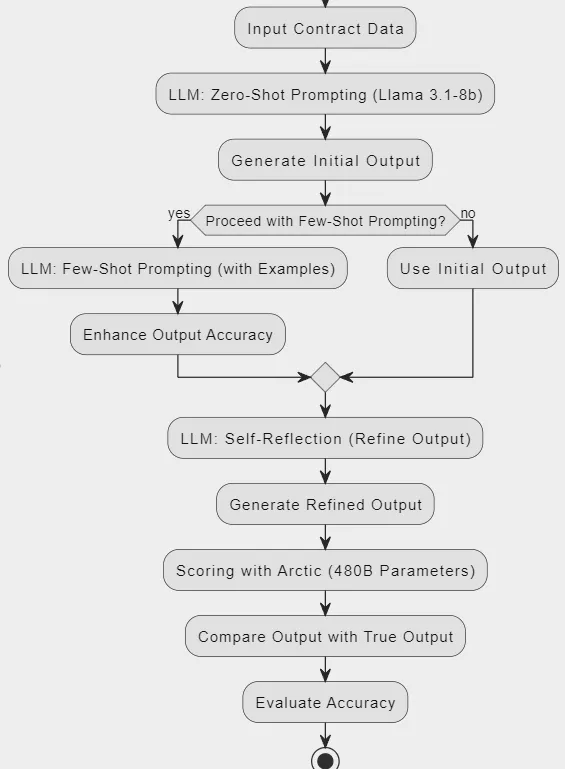

Let’s get started!



In [ ]:
# Import python packages
import streamlit as st
import pandas as pd

# We can also use Snowpark for our analyses!
from snowflake.snowpark.context import get_active_session
session = get_active_session()


You start by importing essential Python packages: Streamlit for creating interactive web apps and Pandas for handling data. Next, you import Snowpark to connect with Snowflake, a powerful cloud-based data platform. You retrieve the active Snowflake session using get_active_session(), allowing you to execute queries and perform data operations directly within Snowflake.

In [ ]:
USE DATABASE CONTAINER_RUNTIME_LAB;
USE SCHEMA NOTEBOOKS;

SELECT * FROM CONTRACTANALYSIS;

I have created a Dummy dataset which I am loading here.



The dataset consists of unstructured contract information, detailing agreements between two parties (Party A and Party B), including key contract dates like effective and termination dates, renewal options, obligations for each party, and dispute resolution methods. It provides structured insights into various contracts by summarizing critical data points like payments, services, and legal jurisdictions

In [ ]:
# Then, we can use the python name to turn cell2 into a Pandas dataframe
df = cell2.to_pandas()
df.drop(columns=['DISPUTERESOLUTION'], inplace=True)
df.head()

You convert the Snowflake DataFrame (referred to as cell2) into a Pandas DataFrame using .to_pandas(). Then, you remove the column labeled DISPUTERESOLUTION using drop(), which allows you to simplify the dataset by eliminating unnecessary information.

Now, let’s create some helper functions

In [ ]:
from snowflake.cortex import Complete

print(Complete("snowflake-arctic", "Hello, How are you doing?"))

In [ ]:
import json

def maketrueoutput(i):
    return f"""{{
  "PartyA": "{df['PARTYA'][i]}",
  "PartyB": "{df['PARTYB'][i]}",
  "EffectiveDate": "{df['EFFECTIVEDATE'][i]}",
  "TerminationDate": "{df['TERMINATIONDATE'][i]}",
  "RenewalOption": "{df['RENEWALOPTION'][i]}",
  "ObligationsA": "{df['OBLIGATIONSA'][i]}",
  "ObligationsB": "{df['OBLIGATIONSB'][i]}"
}}"""

def check(Output, TrueOutput):

    Prompt = """
You are given two JSON objects. Your task is to evaluate their similarity by comparing their structures, keys, and values. Return only a single numerical value between 0 and 1, where 0 indicates no match and 1 indicates an exact match. Do not include any code, explanations, or additional text—just the numerical value.
    """
    Input = "{} First Json - {} Second Json-{}".format(Prompt, Output, TrueOutput)
    print(Output)
    print(TrueOutput)
    return Complete("llama3.1-405b", Input)

You define two functions. The maketrueoutput(i) function generates a JSON structure from your Pandas DataFrame, formatting the contract data for a specific row (i). The check() function compares two JSON objects, evaluating their similarity using a model, which returns a score between 0 (no match) and 1 (exact match). This helps ensure data accuracy during comparisons.

Now, we will do the Zero-Shot Prompting

##Zero-Shot Prompting

In [ ]:
#Zero Shot Prompting

score = 0
for i in range(20):
    Prompt = "You are given an Unstructred Data, return it as a structured Format in the form of JSON. The text is as follows - {}. Return only the JSON, nothing more".format(df['UNSTRUCTUREDDATA'][i])
    Output = Complete("llama3.1-8b", Prompt)
    TrueOutput = maketrueoutput(i)
    score += float(check(Output,TrueOutput))
print(score)

We get a score of 7.99 out of 20, thus there is good room for improvement.



##Few Shot Prompting

In [ ]:
#Few Shot Prompting

Prompt = """"You are given an Unstructred Data, return it as a structured Format in the form of JSON.
The Output format is as below
{
  "PartyA": "Party A"
"PartyB": "Party B"
  "EffectiveDate": "01-01-204",
  "TerminationDate": "01-01-2026",
  "RenewalOption": "True",
  "ObligationsA": "Payment of $5000 per month",
    "ObligationB": "Provide monthly financial reports"
}
Return only the json, nothing more
The text is as follows"""
score = 0
for i in range(20):
    Input = "{} - {}".format(Prompt, df['UNSTRUCTUREDDATA'][i])
    Output = Complete("llama3.1-8b", Input)
    TrueOutput = maketrueoutput(i)
    score += float(check(Output,TrueOutput))
print(score)

In Few-Shot Prompting, you provide the model with an example format of the structured JSON you want, which helps guide its responses. This prompt includes a sample JSON output, so the model understands the structure you expect. The for loop applies the model to 20 rows of unstructured data, comparing each output against the true JSON, and summing the similarity scores.

Few-Shot Prompting is typically better than Zero Shot because it gives the model a concrete example, which improves accuracy and consistency in structuring the data. By seeing the desired format, the model is more likely to follow it closely, reducing errors.

We get a score of 15.57, quite an improvement.

Finally, we do Self-Reflexion!

## Self-Reflexion

In [ ]:
#Self-Reflexion

Prompt = """
You would be provided with a output in the json format. Make sure it satisfies the correct structure for the given unstructured input text.
The Output format should be as follows:

{
  "PartyA": "Party A"
"PartyB": "Party B"
  "EffectiveDate": "01-01-204",
  "TerminationDate": "01-01-2026",
  "RenewalOption": "True",
  "ObligationsA": "Payment of $5000 per month",
    "ObligationB": "Provide monthly financial reports"
}

The text and possible output is as follows. Make sure always all the Keys are present.
Analyze the values of each keys and make sure it matches the correct format.
Recheck the values of Renewal Options, Obligations Thoroughly and make sure they are correct.
Make sure the date is in Correct Format.
Return only the Corrected Json, nothing More. No Code, No explaination. Just the Json as the output
"""
score = 0
for i in range(20):
    Input1 = "{} - {}".format(Prompt, df['UNSTRUCTUREDDATA'][i])
    Output1 = Complete("llama3.1-8b", Input1)
    Input2 = "{} Text is {} It's Structured Format is {}".format(Prompt, df['UNSTRUCTUREDDATA'][i], Output1)
    Output2 = Complete("llama3.1-8b", Input2)
    TrueOutput = maketrueoutput(i)
    score += float(check(Output2,TrueOutput))
print(score)

In Self-Reflection, the model critically reviews its own output before returning the final response. The initial Prompt provides a structured JSON format and guidelines for verifying each key and value (such as dates, obligations, and renewal options). In the loop, after generating a first output, the model is asked to analyze and recheck it for errors, ensuring that all keys are correct and in the expected format. The corrected JSON is then compared to the true output, and the accuracy score is updated.

Self-Reflection is the best method because the model actively critiques and refines its own response, reducing the chances of errors. By prompting the model to validate and adjust its work, this approach leads to more accurate, reliable results compared to both Zero-Shot and Few Shot prompting. It ensures deeper consistency and correctness, especially in complex tasks like parsing contracts.

We get a score of 16.107

In [ ]:
def main(query):

    Prompt = """
    You would be provided with a output in the json format. Make sure it satisfies the correct structure for the given unstructured input text.
    The Output format should be as follows:

    {
      "PartyA": "Party A"
    "PartyB": "Party B"
      "EffectiveDate": "01-01-204",
      "TerminationDate": "01-01-2026",
      "RenewalOption": "True",
      "ObligationsA": "Payment of $5000 per month",
        "ObligationB": "Provide monthly financial reports"
    }

    The text and possible output is as follows. Make sure always all the Keys are present.
    Analyze the values of each keys and make sure it matches the correct format.
    Recheck the values of Renewal Options, Obligations Thoroughly and make sure they are correct.
    Make sure the date is in Correct Format.
    Return only the Corrected Json, nothing More.
    """

    Input1 = "{} - {}".format(Prompt, df['UNSTRUCTUREDDATA'][i])
    Output1 = Complete("llama3.1-8b", Input1)
    Input2 = "{} Text is {} It's Structured Format is {}".format(Prompt, df['UNSTRUCTUREDDATA'][i], Output1)
    Output2 = Complete("llama3.1-8b", Input2)
    return Output


#Streamlit App

In [ ]:
st.title("Automated Contract Analysis")

# Input: Take a query from the user
query = st.text_input("Enter your query")

if query:
     st.write(main(query))

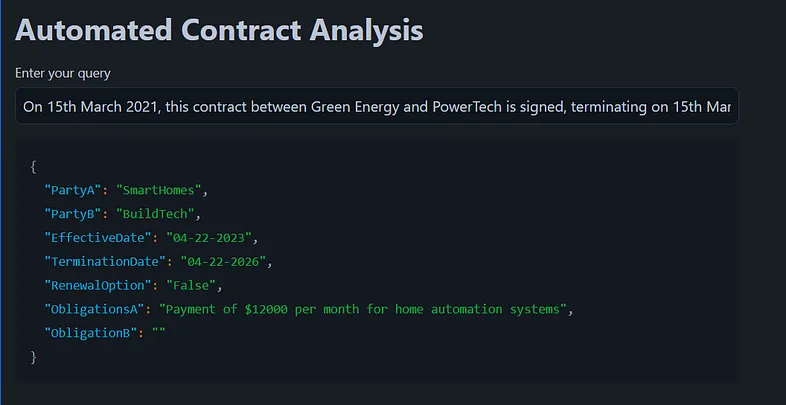

##Conclusion
In conclusion, Self-Reflexion emerges as the most effective method, closely followed by Few-Shot, due to its ability to refine the model’s output through self-analysis and correction. True-Output, being the benchmark, demonstrates the ideal performance, but Self-Reflexion comes remarkably close, indicating its strength in improving accuracy. Zero-Shot, while fast, proves less reliable, highlighting the importance of providing structured examples or allowing for self-correction. Overall, incorporating feedback mechanisms significantly enhances the quality of model-generated outputs.

##Resources
1. https://medium.com/@ingridwickstevens/extract-structured-data-from-unstructured-text-using-llms-71502addf52b
2. https://www.promptingguide.ai/
3. https://docs.snowflake.com/en/user-guide/snowflake-cortex/llm-functions